# Uncertainty estimation example

In this example, we will demonstrate how to use the AEM toolbox and the MCMC toolbox for simple uncertainty estimation. 

## Step 1: Preparation

Before we set up the model, there are a few preparation steps we must first cover. As always, we start by loading in the necessary libraries:

In [1]:
# First, we load a number a libraries we require in the process
import numpy as np # For math arrays
import pickle      # To load in files we prepared in advance
import copy        # To duplicate variables


# Libraries for plotting
import matplotlib.pyplot as plt # For plotting
import matplotlib  # To identify points outside the domain of interest

# Load all functions from the AEM and MCMC toolboxes
from toolbox_AEM import *
from toolbox_MCMC import *

# Set a random seed
np.random.seed(0)

Next, let us prepare some basic information and geometry for the model. In many cases, it makes sense to prepare the geometries of the elements we wish to use in advance. 

In [2]:
# Define the model domain
domain_center   = [0,0]
domain_radius   = 250

# We will require the geometry of the elements; we could just define them 
# manually - as a numpy array with two columns for the x and y coordinates - 
# but we have prepared some of the necessary files in advance.
river           = pickle.load(open('synth_case_river.p','rb'))
noflow          = pickle.load(open('synth_case_noflow.p','rb'))
inhomogeneity   = pickle.load(open('synth_case_inhomogeneity.p','rb'))

# This is just the no-flow boundary with some additional vertices we will
# use for masking evaluation points outside the area of interest later
noflow_cs       = pickle.load(open('synth_case_noflow_cellselect.p','rb'))

## Step 2: Model creation

We start by initializing the model domain, specifying its bottom elevation (`525` m) and the aquifer type (`'unconfined'`). The center and extent of the circular model domain must also be provided.

In [3]:
ml = Model(
    head_offset     = 525,
    aquifer_type    = 'unconfined',
    domain_center   = domain_center,
    domain_radius   = domain_radius)

**Möbius base flow element**

The Möbius base flow element is the first element for which we consider uncertain variables. We set all six* of the Möbius base flow element's variables  (r, head_min, head_max, k) as random. We mark the variables as such by specifying their strings in a list.

*remember that `r` consists of three uncertain rotations

In [4]:
variables_mb    = ['r','head_min','head_max','k']

For some variables like hydraulic conductivities, we may prefer to define them in terms of a base 10 logarithm rather than in the canonical value range used by the model. For such variables, we can define a `converter` and `deconverter` function which transforms the variable for the Bayesian inference

In [5]:
def converter_log10(x):
    # This function converts x from canonical space to log10 space
    from numpy import log10
    return log10(x)

def deconverter_log10(x):
    # This function converts x from log10 space back into canonical space
    return 10**x

Uncertainty estimation requires prior information for all uncertain variables. Consequently, for every entry in 'variables', we must provide a dictionary specifying its prior probability density function. If you are unfamiliar with probability distributions, I recommend experimenting with the most common distributions until you find one which fits your prior belief:

- *beta* (`scipy.stats.beta.pdf(x,a,b)`): useful for variables with fixed upper or lower bounds; adjust the parameters `a` and `b`
- *normal* (`scipy.stats.norm.pdf(x,loc,scale)`): useful for variables without bounds (or those converted to have none, such as log-conductivities); adjust the parameters `loc` (mean) and `scale` (standard deviation)
- *exponential* (`scipy.stats.expon.pdf(x,loc,scale)`): useful for variables with a lower but no upper bound, and whose plausibility decreases away from the lower bound; adjust the parameters `loc` and `scale`
- *vonmises* (`scipy.stats.vonmises.pdf(x,kappa,loc,scale)`): useful for circular variables like rotations; adjust the parameters `kappa`, `loc`, and `scale`
- *gamma* (`scipy.stats.gamma.pdf(x,a,loc,scale)`): useful for variables with a lower but no upper bound, but more flexible than the exponential distribution; adjust parameters `a`, `loc`, and `scale`

For this toolbox, we define the priors as a list of dictionaries, with each list entry/dictionary corresponding to one entry in 'variables'.

We are also free to specify 'limits', for which three options are available:
   - strict numerical values for strict numerical limits
   - `None` to set an upper or lower limit as undefined
   - a string of another random variable of this element to set it as a 
     dynamic limit

Note that the probability density and updates of 'k' are defined in logarithmic space, so we specify its 'convert' and 'deconverter' in its prior dictionary. All other keywords except "name" define properties of the prior distribution

In [6]:
priors_mb       = [
    
    {'name'             : '$\u03C6_A$, $\u03C6_B$, $\u03C6_C$',
      'distribution'    : 'vonmises',
      'kappa'           : 1E-4,
      'loc'             : np.asarray([-0.4,0.1,0.8])*np.pi,
      'scale'           : 1},
    
    {'name'             : '$head_{min}$',
      'distribution'    : 'norm',
      'loc'             : 537,
      'scale'           : 2.5,
      'limits'          : [530, 'head_max']},
    
    {'name'             : '$head_{max}$',
      'distribution'    : 'norm',
      'loc'             : 540,
      'scale'           : 2.5,
      'limits'          : ['head_min', None]},
    
    {'name'             : '$k_{background}$',
      'distribution'    : 'norm',
      'converter'       : converter_log10,
      'deconverter'     : deconverter_log10,
      'loc'             : -4,
      'scale'           : 0.5,
      'limits'          : [-7,-1]}]

Now we can define the base flow element. The Möbius transformation also includes two other variables which define further properties of this element:
  - use_SC    : this flag determines whether the Schwarz-Christoffel map is  used in generating this element. If False, the Möbius transform is applied directly to uniform flow.
  - angular_limit : this variable prevents the Möbius control points A, B, and C from moving closer to each other than the specified distance in radians. This is only used if `r` is among the uncertain variables, and is intended to prevent too extreme curvature in the regional base flow.

In [7]:
ElementMoebiusBase(
    model           = ml,
    r               = np.asarray([0,0.5,1])*np.pi,
    head_min        = 537,
    head_max        = 540,
    k               = 1E-4,
    variables       = variables_mb,
    priors          = priors_mb,
    use_SC          = True,
    angular_limit   = 1)

**Prescribed head / river element**

Now we get to define the river, implemented as a prescribed head boundary of uncertain connectivity to the aquifer. A connectivity value of zero means that this boundary has zero influence on the groundwater table, a value of one means that the groundwater table is completely controlled by the river. To make this variable uncertain, we mark it as such:

In [8]:
variables_hb    = ['connectivity']

Similarly to the Möbius base, we must define it's prior. Since this random variables must take values between 0 and 1, a beta distribution is a good choice:

In [9]:
priors_hb       = [
    
       {'name'              : '$c_{1-4}$',
        'distribution'      : 'beta',
        'a'                 : 2,
        'b'                 : 4,
        'size'              : 4}]

Note that we can define connectivity in two ways: spatially uniform or spatially heterogeneous. In the former case, 'connectivity' is simply a scalar value. In the latter case, 'connectivity' is a vector of length $N > 2$, where $N$ is the number of connectivity nodes. These are placed by normalized distances $0 \leq d \leq 1$ along the element in the 'connectivity_normdist' variable. We subsequently assign the connectivity to each segment through linear interpolation between the nodes.

Mind also that the variable 'segments' allows us to subdivide the element more finely than the specified geometry (`line` and `line_ht`). This process tries to create segments of equal length. The more segments, the better the resolution of the element (no-flow boundaries, for example, may not work with an insufficient resolution), but increases computational cost.

Now we can define the boundary:

In [10]:
ElementHeadBoundary(
    model                   = ml, 
    line                    = river,
    line_ht                 = np.linspace(535,545,river.shape[0]),
    segments                = 100,
    connectivity_normdist   = np.asarray([0.,0.33,0.66,1.]),
    connectivity            = np.asarray([0.75,0.75,0.75,0.75]),
    variables               = variables_hb,
    priors                  = priors_hb)

**Inhomogeneity element**

For the inhomogeneity in the northern part of the model domain, we only have a single uncertain variable: the hydraulic conductivity. It is defined the same way as we did in the Möbius base flow element.

First by marking it as uncertain...

In [11]:
variables_in    = ['k']

...then defining its prior, where we use the same converter and deconverter we created before:

In [12]:
priors_in       = [
    
        {'name'             : '$k_{inhomogeneity}$',
          'distribution'    : 'norm',
          'converter'       : converter_log10,
          'deconverter'     : deconverter_log10,
          'loc'             : -5,
          'scale'           : 0.5,
          'limits'          : [-7,-1]}]

With this, we can define the inhomogeneity.

In [13]:
ElementInhomogeneity(
    model           = ml,
    k               = 1E-5,
    polygon         = inhomogeneity,
    segments        = 300,
    variables       = variables_in,
    priors          = priors_in)

**Extraction well element**

Finally, we can add the extraction well and the no-flow boundary in the south. Since we set no variable of either element as random, their definition is rather straightforward.

First add the extraction well...

In [14]:
ElementWell(
    model           = ml,
    zc              = [-50,30],
    rw              = 0.1,
    strength        = -0.0025)

**No-flow boundary element**

...then the no-flow boundary.

In [15]:
ElementNoFlowBoundary(
    model           = ml,
    line            = noflow,
    segments        = 100)

**Model evaluation**

Before we define the MCMC object, let us first take a look at the model we have defined so far.

Towards this end, we require points at which we evaluate the model. Since our model domain is circular, we are interested in points within the disk. We could, for example, simply create a meshgrid and mask all points inside. In this toolbox, however, we have included a function which automatically creates a collection of equi-distant points within a disk. The number of rings corresponds to the resolution of the grid.

In [16]:
XY = equidistant_points_in_circle(
    rings           = 31,
    radius          = domain_radius)

# We may not want to evaluate the points beyond the no-flow element, so we mask 
# those by removing them from our collection of evaluation points.
linepath    = matplotlib.path.Path(noflow_cs)
indices     = linepath.contains_points(XY)
XY          = XY[~indices,:]

After definition, we can evaluate the AEM. Simply call the model.evaluate function with the specified evaluation points (XY) and the desired mode. Possible modes are `'head'` (hydraulic head), `'potential'` (complex potential), and `'gradient'` (which returns the gradient, with the x coordinate being the real and the y coordinate the imaginary part; the variable `derivatives` defines whether the user wishes to obtain the derivatives of the hydrualic potential (`'phi'`) or the stream function (`'psi'`)).

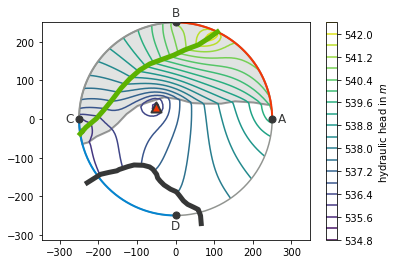

In [17]:
z = ml.evaluate(XY,mode='head') 

# We have also added a rudimentary function to plot the elements the user 
# defined before.
ml.plot()

# Now let's add the contours of our model results.
plt.tricontour(XY[:,0],XY[:,1],np.real(z),levels=21)
plt.colorbar(label='hydraulic head in $m$')

# And make sure the axes are equally spaced.
plt.axis('equal')

# Tricontour will also interpolate over the no-flow boundary; mask this area
plt.fill(noflow_cs[:,0],noflow_cs[:,1],facecolor='w',zorder=2)

## Step 3: Uncertainty estimation with MCMC

Now we may can start the Bayesian inference with MCMC. Towards this end, we must first define the observations we use for the determination of the likelihood. The observations are defined similarly to the priors and proposals, as a list of dictionaries. Each dictionary contains an (optional) `'name'`, a `'location'` as complex coordinates, and an associated `'head'` measurement.

In [18]:
observations    = [
    
    {'name'         : 'Observation 1',
     'location'     : -50+30j,
     'head'         : 535.36},
    
    {'name'         : 'Observation 2',
     'location'     : 10-100j,
     'head'         : 538.71},
    
    {'name'         : 'Observation 3',
     'location'     : 100+115j,
     'head'         : 539.80},
    
    {'name'         : 'Observation 4',
     'location'     : -175+85j,
     'head'         : 536.93}]

We must also define a dictionary for the likelihood distribution. In this implementation, we assume that the same likelihood function is used for all observations. If we use a Gaussian pdf ('norm'), we need only define the scale (standard deviation). The mean ('loc') will be defined by the model prediction, and the evaluation point ('x') by the observation (`'head'` in the dictionary entries of the list `observations` ).

In [19]:
likelihood_dictionary   = {
        'distribution'      : 'norm',
        'scale'             : 0.15}

With this, we can start defining the MCMC class. Our Python implementation is based on the Differential Evolution Markov Chain algorithm (DE-MC), whose corresponding publication is available under DOI 10.1007/s11222-006-8769-1. The MCMC function in our toolbox requires the following variables:
    
  - `model`: The model object with which this MCMC object should be associated. This is where we plug in the AEM model.
  
  - `walkers`: The number of parallel walkers used to explore the uncertainty distribution. Always use more walkers than you have uncertain variables.
  
  - `chain_length`: How many entries the chain of each walker should collect.The higher this number, the more extensive the inference result becomes, at higher computational expense.
  
  - `ensemble`: Either an array of shape $N_{walkers}$-by-$N_{variables}$ or `None`, in which case a valid starting ensemble will be automatically sampled based on the prior information provided.
  
  - `observations`: This is where we introduce the observations list defined above, used to calculate the likelihood.
  
  - `likelihood_dictionary`: The dictionary specifying the properties of the likelihood function.
  
  - `cutoff`: finite MCMC chains often require a certain period until they have found regions of high probability density. This initial phase is often called the "burn-in". The number entered here is added to the chain_length, and discards the first *cutoff* entries of the chain automatically.
  
  - `epsilon`: the DE-MC algorithm adds a small Gaussian perturbation to ensure it can reach the entire parameter space. This number is the standard deviation of this perturbation and should consequently be small.
  
  - `flat`: this flag decides whether the results are returned as individual chains or concatenated into a single chain.
  
  - `clean_chains`: sometimes, the burn-in period is not sufficient to let every chain converge; this flag activates or deactivates an additional post-processing routine, removing all samples before each walker's chain first crosses above a  10% range around the mean logposterior of all chains.
  
To speed up this example, we have prepared an ensemble already converged towards a region of high probability density in advance. Note that the `chain_length` and `cutoff` we use here for demonstration purposes are a lot shorter than they should be in a real application. For this reason, we also set `clean_chains` to `False`. In a real application, we suggest setting it to `True` instead.

In [20]:
ensemble = pickle.load(open('synth_case_ensemble.p','rb'))

mcmc = MCMC(
    model                   = ml,
    walkers                 = 24,
    chain_length            = 20,
    ensemble                = ensemble,
    observations            = observations,
    likelihood_dictionary   = likelihood_dictionary,
    cutoff                  = 0,
    epsilon                 = 1E-6,
    flat                    = True,
    clean_chains            = False) # I recommend to use "clean_chains = True" in real applications

With the MCMC base defined, let us start the algorithm. Depending on the computational power of your computer, this can take quite a while. Since we only defined 20 steps for each walker here (resulting in a total chain length of $20\cdot24=480$, the chain should finish in about a minute).

In [21]:
mcmc.start()

--------------------------------------------------------------
iteration counter / acc. rate (last 100 steps) / acc. (overall) : posterior density ratio
                                                     
MCMC run finished.


When doing uncertainty quantification with MCMC, it is always useful to take a look at the chain to see whether it has correctly converged. In this example, there is not much point in doing so, since our `chain_length` is very short, but the chain can be plotted with the following in-built function:

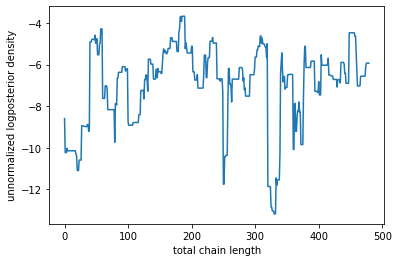

In [22]:
mcmc.plot_chain()

We can also plot the parameter uncertainty of the chain. Note that this plot can become very large and inefficient if the number of uncertain variables becomes too large. In such cases, I recommend plotting the parameter uncertainty manually. Due to the low chain length in this small example, this plot is not very comprehensive, but it should get the idea across: parameter combinations in regions with higher-valued contours (here: yellow) tend to be combinations of higher posterior probability density than those with lower-valued contours (here: dark blue).

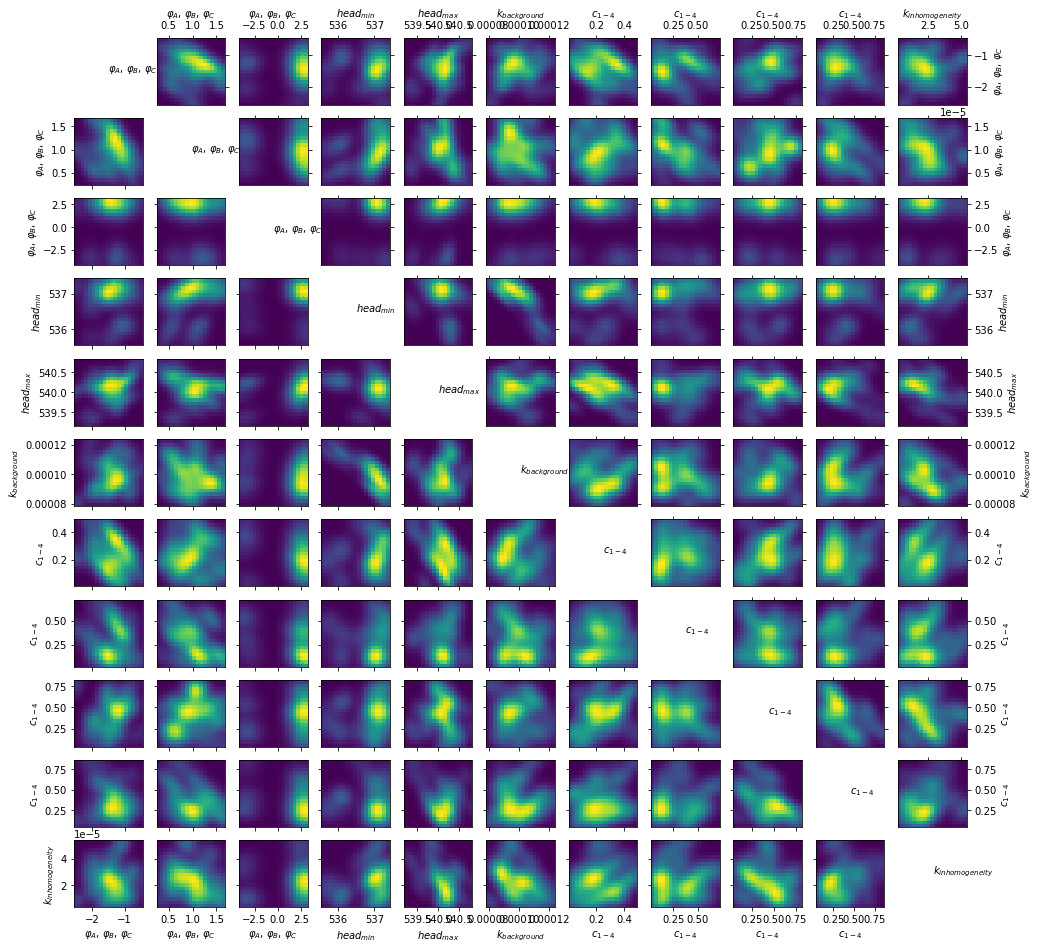

In [23]:
plt.figure(figsize=(16,16))
mcmc.plot_parameter_uncertainty()

As of now, MCMC has only evaluated the model at the observation wells (recall that AEM does not require you to evaluate it everywhere). If we wish to plot the uncertainty in the flow fields, we should evaluate the model everywhere. This can be done with the function `evaluate_chain`. Since it can be computationally very expensive to evaluate every single entry in the chain, we can further subsample the ensemble. `subsampling` of `0.1` means that only 10% of the entries in the chain are being evaluated, and the `subsampling_type` can be either `'incremental'` (evaluate every 10th entry) or `'random'` (10% randomly selected entries are evaluated).

In [24]:
evaluation_dictionary = mcmc.evaluate_chain(
    z                       = XY,
    subsampling             = 1.0, 
    subsampling_type        = 'incremental')

The function `evaluate_chain` prepares an evaluation_dictionary which contains all information required to plot the state uncertainty. To plot the hydraulic head uncertainty, let us first calculate the mean and standard deviation of the hydraulic head entries. Mind that the chain we  we evaluated might still contain duplicates. However, we stored it only with the unique samples, and kept count of how often each sample is retained in `evaluation_dictionary['chain_duplicates']`. We have provided an in-built function to calculate the mean and standard deviation, which can be accessed as:

In [25]:
mean, std = weighted_avg_and_std(
    values      = np.asarray([np.real(entry) for entry in evaluation_dictionary['results']]), 
    weights     = evaluation_dictionary['chain_duplicates'])

With this, we can start plotting the results. Here, we plot the hydraulic head uncertainty as a figure with the hydraulic head mean on the left side, and its standard deviation on the right side:

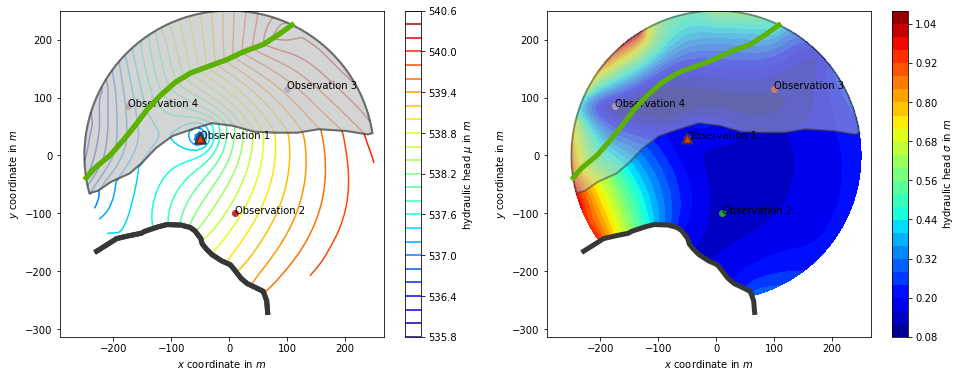

In [26]:
# Now start plotting the average hydraulic head distribution
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
for element in ml.elementlist[1:]:
    element.plot()
plt.tricontour(
    np.real(evaluation_dictionary['z']),
    np.imag(evaluation_dictionary['z']),
    mean,
    levels  = 25,
    cmap    = 'jet',
    zorder  = 1)
plt.axis('equal')
plt.colorbar(label='hydraulic head $\mu$ in $m$')
plt.xlabel('$x$ coordinate in $m$')
plt.ylabel('$y$ coordinate in $m$')

# Mask the are behind the no-flow boundary
plt.fill(noflow_cs[:,0],noflow_cs[:,1],facecolor='w',zorder=2)

# And scatter the observation well locations
for entry in observations:
    
    plt.scatter(
        np.real(entry['location']),
        np.imag(entry['location']))
    plt.text(
        np.real(entry['location']),
        np.imag(entry['location']),
        entry['name'])
    
# Plot the elements
for element in ml.elementlist[1:]:
    element.plot()

# Plot the hydraulic head standard deviation in the second subplot
plt.subplot(1,2,2)
plt.tricontourf(
    np.real(evaluation_dictionary['z']),
    np.imag(evaluation_dictionary['z']),
    std,
    levels  = 25,
    cmap    = 'jet',
    zorder  = 1)
plt.axis('equal')
plt.colorbar(label='hydraulic head $\sigma$ in $m$')
plt.xlabel('$x$ coordinate in $m$')
plt.ylabel('$y$ coordinate in $m$')

# Mask the are behind the no-flow boundary
plt.fill(noflow_cs[:,0],noflow_cs[:,1],facecolor='w',zorder=2)

# And scatter the observation well locations
for entry in observations:

    plt.scatter(
        np.real(entry['location']),
        np.imag(entry['location']))
    plt.text(
        np.real(entry['location']),
        np.imag(entry['location']),
        entry['name'])
    
# Plot the elements
for element in ml.elementlist[1:]:
    element.plot()

Uncertainties are usually lowest near the observation wells and increase farther away from them. The reason for this is that the MCMC algorithm decides whether to accept or reject a proposal based on how large its product of prior (our initial judgement about the probability of the hypothesis) and likelihood (how closely its predictions match the observations*) is relative to its current reference (the last entry in the chain). This favours accepting samples which reproduce the observations. Since we do not observe the full system, but only a few point-wise water tables, parameter sets which yield similar predictions at the observation wells but disagree about the water table farther out may be functionally indistinguishable for the algorithm. This results in larger standard deviations away from the observation wells.

Of course, the longer the chain is, the more comprehensive the uncertainty estimate becomes, as the algorithm explores more and more possibilities. If you have any remaining questions, please don't hesitate to contact me under whatever e-mail address is currently listed at https://orcid.org/0000-0003-3508-6214.

Good luck!

*actually, it is the opposite: the likelihood measures how probable the observations are given the model predictions